# PORTFOLIO MOVING AVERAGE (PMA)

In [1]:
import pandas as pd
import itable
import ffn
import talib

%matplotlib inline

def side_by_side(*objs, **kwds):
    from pandas.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))

In [2]:
def monthly_return_table (daily_prices) :
    #monthly_returns = daily_prices.resample('M').last().pct_change()
    monthly_returns = daily_prices.resample('M', how='last').pct_change()
    df = pd.DataFrame(monthly_returns.values, columns=['Data'])
    df['Month'] = monthly_returns.index.month
    df['Year']= monthly_returns.index.year
    table = df.pivot_table(index='Year', columns='Month').fillna(0).round(4) * 100
    #annual_returns = daily_prices.resample('12M').last().pct_change()[1:].values.round(4) * 100
    annual_returns = daily_prices.resample('12M', how='last').pct_change()[1:].values.round(4) * 100
    if len(table) > len(annual_returns) :
        table = table[1:]
    table['Annual Returns'] = annual_returns
    return table

In [3]:
def endpoints(start=None, end=None, period='m', trading_days=None) :
    
    if trading_days is not None:
        dates = trading_days
# the following 2 lines cause python 3.4.2 to crash, so removed them
#    elif start is not None and end is not None:
#        dates = tradingcalendar.get_trading_days(start, end)
    else:
        print ('\n** ERROR : must either provide pandas series (or df) of trading days \n')
        print ('           or a start and end date\n')
    
    if isinstance(period, int) :
        dates = [dates[i] for i in range(0, len(dates), period)]
    else :    
        if period == 'm' : months = 1
        elif period == 'q' : months = 3
        elif period == 'b' : months = 6
        elif period == 'y' : months = 12           
            
        e_dates = [dates[i - 1] for i in range(1,len(dates))\
                          if dates[i].month > dates[i-1].month\
                          or dates[i].year > dates[i-1].year ]+ list([dates[-1]])
        dates = [e_dates[i] for i in range(0,len(e_dates),months)]
    
    return dates

In [4]:
# THIS ONE MATCHES PV
# SEE PV backtest :https://goo.gl/lBR4K9
# AND spreadsheet : https://goo.gl/8KGp58
# and Quantopian backtest : https://goo.gl/xytT5L

def backtest(prices, weights, capital, offset=1, commission=0.) :
    rebalance_dates = weights.index
    buy_dates = [prices.index[d + offset] for d in range(len(prices.index)-1) if prices.index[d] in rebalance_dates ]
    print ('FIRST BUY DATE = {}\n'.format(buy_dates[0]))
    p_holdings = pd.DataFrame(0, index=prices.index, columns=prices.columns)
    cash = 0.
    for i, date in enumerate(prices.index):
        if date in rebalance_dates :
#             print ('--------------------------------------------------------------------') 
            new_weights = weights.loc[date]
            p_holdings.iloc [i] = p_holdings.iloc [i - 1]
        if date in buy_dates :           
            if date == buy_dates[0] :
                p_holdings.loc[date] = (capital * weights.iloc[0] / prices.loc[date])
#                 print ('INIT', cash, p_holdings.iloc[i-1],prices.loc[date], new_weights)
            else :
                portfolio_value = cash + (p_holdings.iloc[i - 1] * prices.loc[date]).sum() * new_weights
                p_holdings.iloc[i] = (portfolio_value / prices.loc[date]).fillna(0)
#                 print ('{} BUY \n{}\n{}\n{}\n{}\n{}\nHOLDINGS\n{}\n'.format(date,cash,portfolio_value,p_holdings.iloc[i-1],
#                                                                     prices.loc[date],new_weights,p_holdings.iloc[i]))
                cash = (portfolio_value - p_holdings.iloc[i] * prices.loc[date]).sum()
#                 print ('{}\nPORTFOLIO VALUE\n{}\nCASH = {}'.format(date, portfolio_value,cash))
        else :
            p_holdings.iloc [i] = p_holdings.iloc [i - 1]
            #print ('{} HOLDINGS UNCHANGED'.format(date))

    p_value = (p_holdings * prices).sum(1)[p_holdings.index>=buy_dates[0]]
#     print(p_holdings, )
    p_weights = p_holdings.mul(prices).div(p_holdings.mul(prices).sum(axis=1), axis=0).fillna(0)
    
    return p_value, p_holdings, p_weights

# PMA001

INCEPTION DATES:

        inception
VCVSX  1986-06-17
VFIIX  1986-06-17
VUSTX  1986-06-17
FIRST BUY DATE = 1986-08-29 00:00:00



G:\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=3).mean()


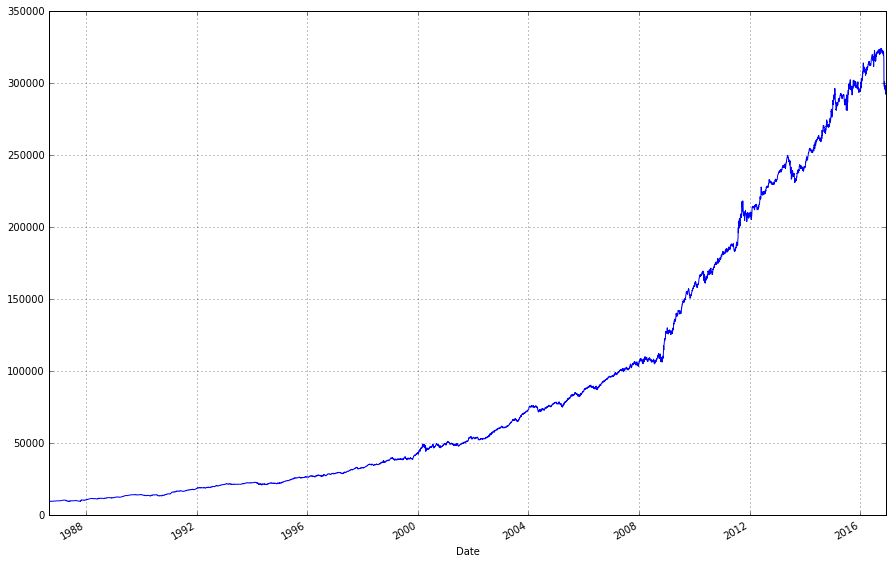

In [5]:
symbols =['VCVSX', 'VFIIX']
cash_proxy = 'VUSTX'

risk_lookback = 3
allocations = [0.6, 0.4]
frequency = 'm'

tickers = list(set(symbols + [cash_proxy]))

data = pd.DataFrame (columns=symbols)
for symbol in tickers :
    url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
    data[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close']
    
inception_dates = pd.DataFrame([data[ticker].first_valid_index().date() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])
                               
print ('INCEPTION DATES:\n\n{}'.format(inception_dates))

prices = data.copy().dropna()

end_points = endpoints(period=frequency, trading_days=prices.index)
prices_m = prices.loc[end_points]

# elligibility rule
# SMA = prices_m.rolling(risk_lookback).mean().dropna()
SMA = pd.rolling_mean(prices_m, risk_lookback).dropna()
rebalance_dates = SMA.index
rule = prices_m.loc[rebalance_dates][symbols] > SMA[symbols]

# fixed weight allocation
weights = allocations * rule

# downside protection
weights[cash_proxy] = 1 - weights[symbols].sum(axis=1)

# backtest
p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

In [10]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 1986-08-29 00:00:00 - 2016-11-29 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
2887.27%            1.62  11.88%  -10.30%

Annualized Returns:
mtd     3m      6m      ytd    1y      3y     5y     10y     incep.
------  ------  ------  -----  ------  -----  -----  ------  --------
-6.77%  -7.23%  -5.73%  1.46%  -0.01%  7.30%  7.73%  12.03%  11.88%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.62     1.66       1.86
mean    11.48%   11.52%     12.16%
vol     7.08%    6.94%      6.55%
skew    0.51     0.46       0.07
kurt    16.28    2.86       -0.30
best    7.76%    12.07%     25.68%
worst   -3.91%   -6.77%     -1.27%

Drawdowns:
max      avg       # days
-------  ------  --------
-10.30%  -0.94%     18.24

Misc:
---------------  ------
avg. up month    1.89%
avg. down month  -1.21%
up year %        96.67%
12m up %  

In [12]:
df

NameError: name 'df' is not defined

In [13]:
def highlight_pos_neg (s) :
    is_positive = s > 0    
    return ['background-color : rgb(127,255,0)' if v else 'background-color : rgb(255,99,71)' for v in is_positive]

df = monthly_return_table (p_value)

df.style.\
    apply(highlight_pos_neg)

AttributeError: 'DataFrame' object has no attribute 'style'

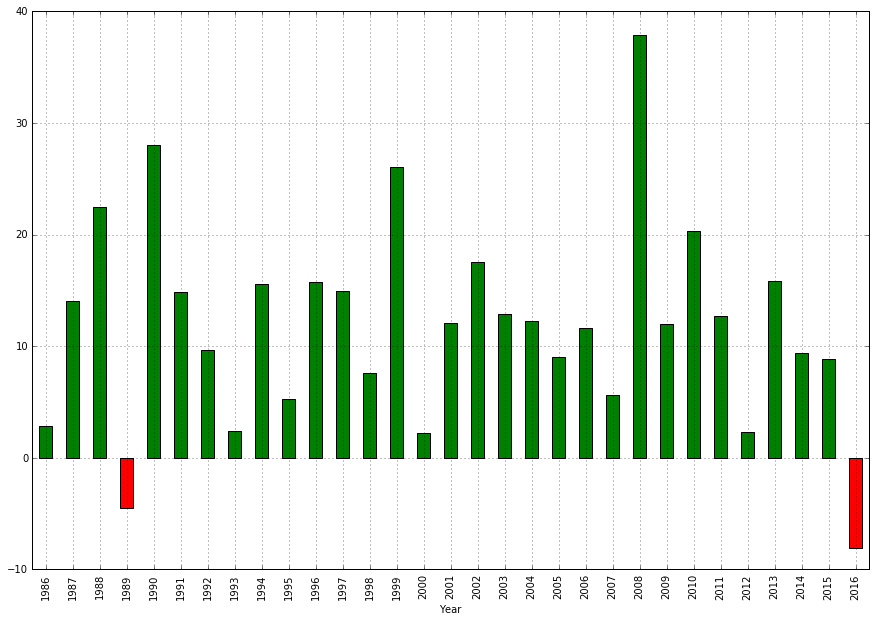

In [9]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

# PMA002

INCEPTION DATES:

        inception
VCVSX  1986-06-17
VWINX  1980-01-02
VWEHX  1980-01-02
VUSTX  1986-05-19
FIRST BUY DATE = 1986-08-29 00:00:00



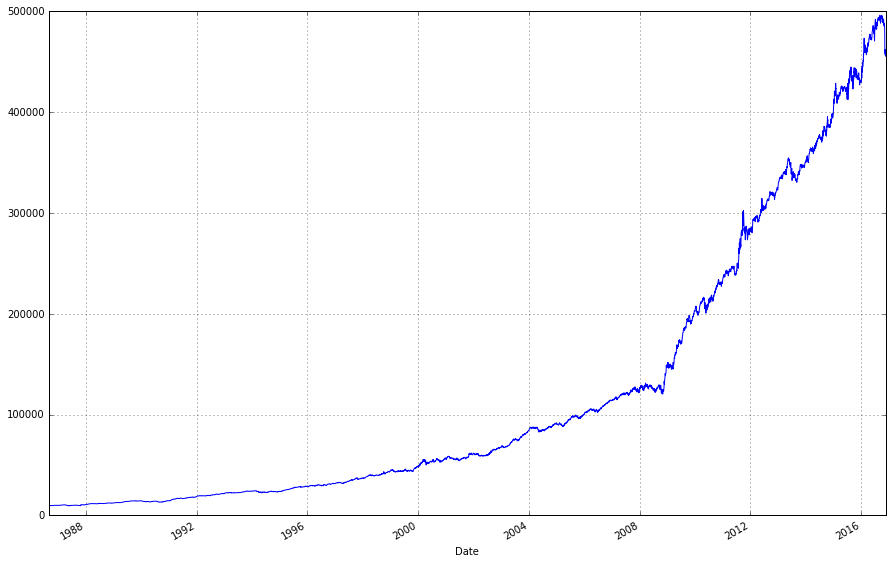

In [11]:
symbols =['VCVSX', 'VWINX', 'VWEHX']
cash_proxy = 'VUSTX'

tickers = list(set(symbols + [cash_proxy]))

start='1985-01-01'
end='2016-11-10'

data = pd.DataFrame (columns=symbols)
for symbol in tickers :
    url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
    data[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close']
    
inception_dates = pd.DataFrame([data[ticker].first_valid_index().date() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])
                               
print ('INCEPTION DATES:\n\n{}'.format(inception_dates))

prices = data.copy().dropna()

end_points = endpoints(period='m', trading_days=prices.index)
prices_m = prices.loc[end_points]

risk_lookback = 3
allocations = [0.6, 0.2, 0.2]

# elligibility rule
# SMA = prices_m.rolling(risk_lookback).mean().dropna()
SMA = pd.rolling_mean(prices_m, risk_lookback).dropna()
rebalance_dates = SMA.index
rule = prices_m.loc[rebalance_dates][symbols] > SMA[symbols]

# fixed weight allocation
weights = allocations * rule

# downside protection
weights[cash_proxy] = 1 - weights[symbols].sum(axis=1)

# backtest
p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

In [12]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 1986-08-29 00:00:00 - 2016-11-23 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
4456.86%            1.65  13.46%  -11.02%

Annualized Returns:
mtd     3m      6m      ytd    1y     3y     5y      10y     incep.
------  ------  ------  -----  -----  -----  ------  ------  --------
-6.42%  -7.77%  -3.85%  6.13%  4.61%  9.58%  10.68%  14.93%  13.46%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.65     1.64       1.75
mean    12.93%   13.00%     13.88%
vol     7.83%    7.91%      7.95%
skew    0.50     0.52       0.90
kurt    13.13    2.17       1.87
best    7.76%    12.07%     37.94%
worst   -3.45%   -6.42%     -1.75%

Drawdowns:
max      avg       # days
-------  ------  --------
-11.02%  -1.08%     19.34

Misc:
---------------  ------
avg. up month    2.15%
avg. down month  -1.39%
up year %        96.67%
12m up %   

In [13]:
def highlight_pos_neg (s) :
    is_positive = s > 0    
    return ['background-color : rgb(127,255,0)' if v else 'background-color : rgb(255,99,71)' for v in is_positive]

df = monthly_return_table (p_value)

df.style.\
    apply(highlight_pos_neg)

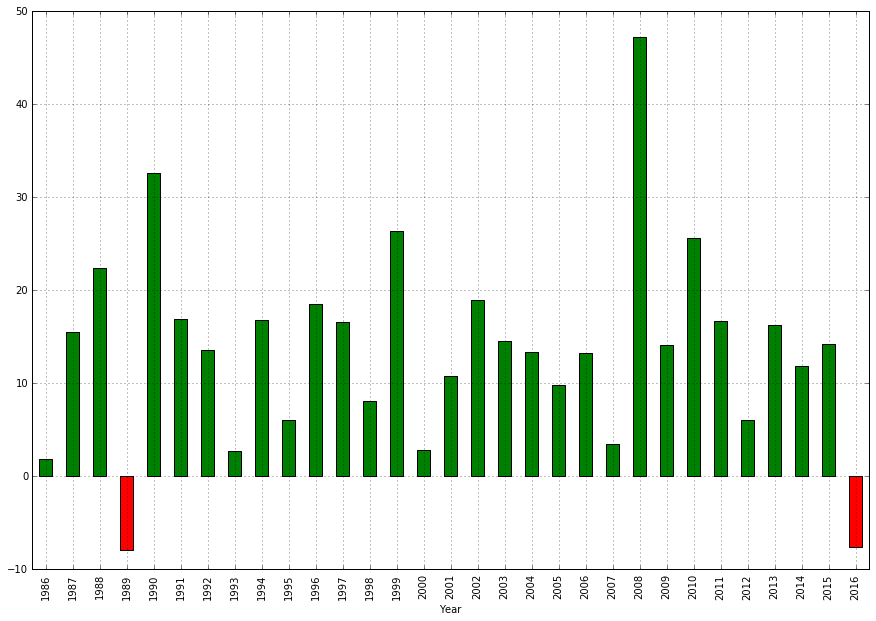

In [14]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

# PMA003

INCEPTION DATES:

        inception
VCVSX  1986-06-17
VWINX  1980-01-02
VWEHX  1980-01-02
VUSTX  1986-05-19
FIRST BUY DATE = 1986-08-29 00:00:00



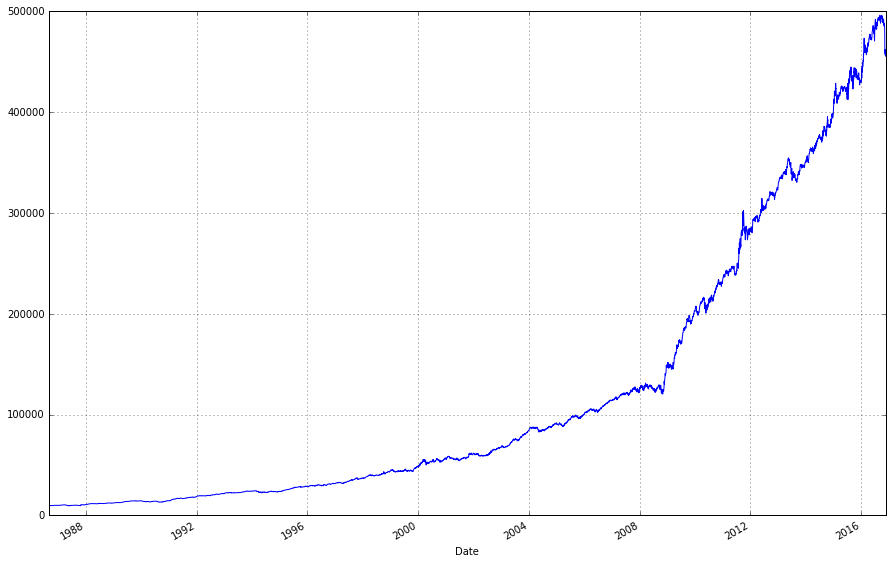

In [15]:
symbols =['VCVSX', 'VWINX', 'VWEHX']
cash_proxy = 'VUSTX'

tickers = list(set(symbols + [cash_proxy]))

start='1985-01-01'
end='2016-11-10'

data = pd.DataFrame (columns=symbols)
for symbol in tickers :
    url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
    data[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close']
    
inception_dates = pd.DataFrame([data[ticker].first_valid_index().date() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])
                               
print ('INCEPTION DATES:\n\n{}'.format(inception_dates))

prices = data.copy().dropna()

end_points = endpoints(period='m', trading_days=prices.index)
prices_m = prices.loc[end_points]

risk_lookback = 3
allocations = [0.6, 0.2, 0.2]

# elligibility rule
# SMA = prices_m.rolling(risk_lookback).mean().dropna()
SMA = pd.rolling_mean(prices_m, risk_lookback).dropna()
rebalance_dates = SMA.index
rule = prices_m.loc[rebalance_dates][symbols] > SMA[symbols]

# fixed weight allocation
weights = allocations * rule

# downside protection
weights[cash_proxy] = 1 - weights[symbols].sum(axis=1)

# backtest
p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

In [16]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 1986-08-29 00:00:00 - 2016-11-23 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
4456.86%            1.65  13.46%  -11.02%

Annualized Returns:
mtd     3m      6m      ytd    1y     3y     5y      10y     incep.
------  ------  ------  -----  -----  -----  ------  ------  --------
-6.42%  -7.77%  -3.85%  6.13%  4.61%  9.58%  10.68%  14.93%  13.46%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.65     1.64       1.75
mean    12.93%   13.00%     13.88%
vol     7.83%    7.91%      7.95%
skew    0.50     0.52       0.90
kurt    13.13    2.17       1.87
best    7.76%    12.07%     37.94%
worst   -3.45%   -6.42%     -1.75%

Drawdowns:
max      avg       # days
-------  ------  --------
-11.02%  -1.08%     19.34

Misc:
---------------  ------
avg. up month    2.15%
avg. down month  -1.39%
up year %        96.67%
12m up %   

In [17]:
def highlight_pos_neg (s) :
    is_positive = s > 0    
    return ['background-color : rgb(127,255,0)' if v else 'background-color : rgb(255,99,71)' for v in is_positive]

df = monthly_return_table (p_value)

df.style.\
    apply(highlight_pos_neg)

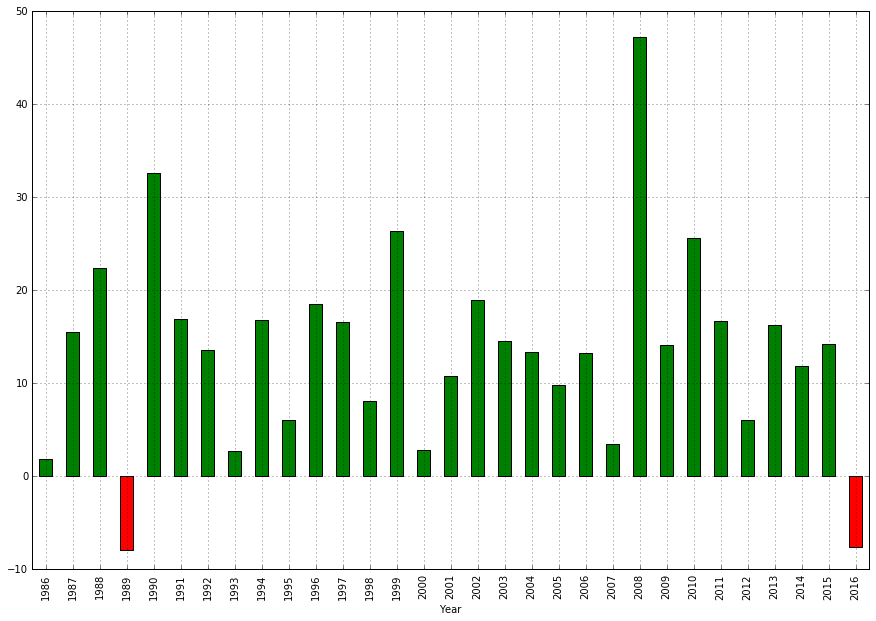

In [18]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

# SCRATCHPAD

RS0001
VCVSX
VWEHX
VFIIX
FGOVX
VWAHX
FIRST BUY DATE = 1986-07-31 00:00:00



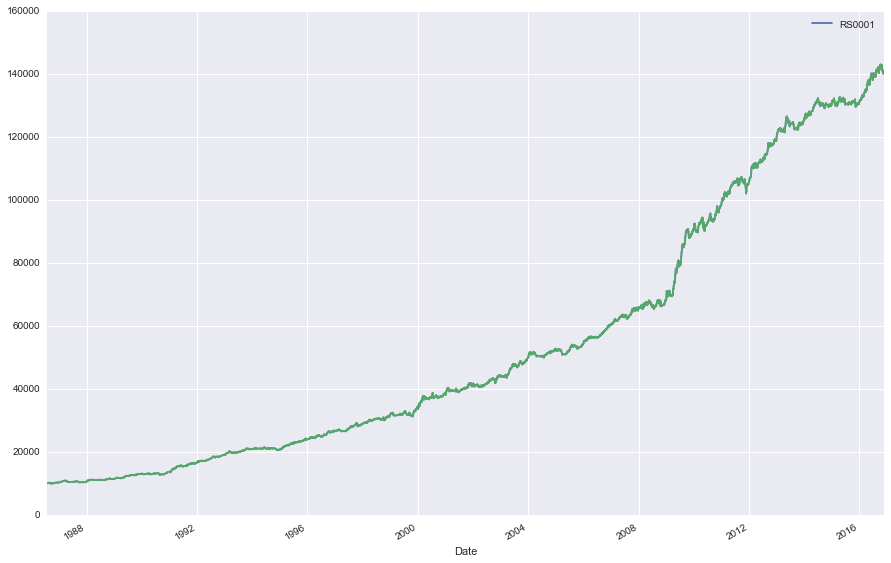

In [4]:
import os
os.chdir('C:\\users\\scuba\\pycharmprojects\\simplebacktester')
os.getcwd()

import pandas as pd

import seaborn
%matplotlib inline

from backtest_helpers.compute_weights_RS_DM import compute_weights_RS_DM
from backtest_helpers.compute_weights_PMA import compute_weights_PMA

portfolios = {
    'RS0001': { 'symbols': ['VCVSX','VWEHX','VFIIX','FGOVX','VWAHX'], 
               'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 2, 'frequency': 'm',
              'cash_proxy': 'CASHX', 'risk_free': 0},   
}

p_value, p_holdings, p_weights =  compute_weights_RS_DM (name, portfolios[name])

p_value.plot(figsize=(15, 10), grid=True)

# SCRATCHPAD

In [7]:
strategies = {
                 'PMA001': {'symbols': ['VCVSX', 'VFIIX'], 'prices': 'yahoo',
                            'risk_lookback': 3, 'frequency': 'M', 'allocations': [0.6, 0.4],
                            'cash_proxy': 'VUSTX'}},

In [14]:
strategies

{'PMA001': {'allocations': [0.6, 0.4],
  'cash_proxy': 'VUSTX',
  'frequency': 'M',
  'prices': 'yahoo',
  'risk_lookback': 3,
  'symbols': ['VCVSX', 'VFIIX']}}